# Notebook 04: Causal Intervention

**Research Question:** Is the action-grounding representation causally relevant to behavior?

This notebook:
1. Extracts probe direction from trained reality probe
2. Runs steering experiments (add/subtract direction)
3. Computes dose-response curves
4. Tests control (random direction)

**Success criteria:** Steering changes tool call rate by >20%

**Note:** This is the most challenging experiment. Null results are acceptable if reported honestly.

## Setup

In [10]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from src.utils.logging import setup_logging
from src.config import get_config
from src.data.io import load_episodes
from src.analysis.probes import load_probe, get_probe_direction
from src.intervention.steering import run_steering_experiment, compute_dose_response, plot_dose_response

setup_logging(level="INFO")
config = get_config()

print("Causal Intervention Experiments")
print(f"Steering config:")
print(f"  Alphas: {config.steering.alphas}")
print(f"  Target layer: {config.steering.target_layer}")
print(f"  Samples per alpha: {config.steering.n_samples_per_alpha}")

Causal Intervention Experiments
Steering config:
  Alphas: [-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0]
  Target layer: 16
  Samples per alpha: 50


## 1. Load Probe and Episodes

In [11]:
# Load trained reality probe
reality_probe = load_probe(config.data.processed_dir / "reality_probe.pkl")

# Get probe direction
probe_direction = get_probe_direction(reality_probe)

print(f"Loaded reality probe")
print(f"  Direction shape: {probe_direction.shape}")
print(f"  Direction norm: {np.linalg.norm(probe_direction):.3f}")

2025-12-26 06:58:58,693 - src.analysis.probes - INFO - Loaded probe from: data/processed/reality_probe.pkl
Loaded reality probe
  Direction shape: (4096,)
  Direction norm: 13.468


In [12]:
# Load episodes
import os
from pathlib import Path

print(f"Current working directory: {os.getcwd()}")
print(f"Script location: {Path(__file__).parent if '__file__' in globals() else 'N/A'}")
episodes_collection = load_episodes("../data/processed/episodes_v2.parquet")

# Filter to interesting cases for steering
# Test 1: Can we steer fake_action (claims but no tool) to actually call tool?
fake_episodes = episodes_collection.get_fake_episodes()

# Test 2: Can we steer true_action to not call tool?
true_episodes = episodes_collection.filter_by_category('true_action').episodes

print(f"\nEpisodes for steering:")
print(f"  Fake actions: {len(fake_episodes)}")
print(f"  True actions: {len(true_episodes)}")

Current working directory: /workspace/action-grounding/notebooks
Script location: N/A
2025-12-26 06:59:00,774 - src.data.io - INFO - Loading episodes from: ../data/processed/episodes_v2.parquet
2025-12-26 06:59:01,025 - src.data.io - INFO - Loaded 1800 episodes

Episodes for steering:
  Fake actions: 122
  True actions: 1258


In [13]:
# Sample episodes for steering (to keep compute manageable)
n_samples = config.steering.n_samples_per_alpha

np.random.seed(42)
if len(fake_episodes) > n_samples:
    fake_sample = np.random.choice(fake_episodes, n_samples, replace=False).tolist()
else:
    fake_sample = fake_episodes

if len(true_episodes) > n_samples:
    true_sample = np.random.choice(true_episodes, n_samples, replace=False).tolist()
else:
    true_sample = true_episodes

print(f"\nSampled for steering:")
print(f"  Fake: {len(fake_sample)}")
print(f"  True: {len(true_sample)}")


Sampled for steering:
  Fake: 50
  True: 50


## 2. Steering Experiment: Fake → True

**Test:** Add probe direction to fake_action episodes. Does this cause tool calls?

In [6]:
# Run steering on fake episodes with positive alphas
# WARNING: This takes ~1-2 hours depending on GPU
# Checkpointing enabled: progress is saved incrementally and will resume if interrupted

checkpoint_path = config.data.processed_dir / "fake_steering_checkpoint.json"

fake_steering_results = run_steering_experiment(
    probe_direction=probe_direction,
    episodes=fake_sample,
    alphas=config.steering.alphas,
    model_id=config.model.id,
    target_layer=config.steering.target_layer,
    verbose=True,
    checkpoint_path=checkpoint_path,
)

print(f"\nCompleted {len(fake_steering_results)} steering experiments on fake episodes")
print(f"Checkpoint saved to: {checkpoint_path}")

2025-12-25 22:25:00,272 - src.intervention.steering - INFO - Initialized SteeringExperiment:
2025-12-25 22:25:00,275 - src.intervention.steering - INFO -   Model: mistralai/Mistral-7B-Instruct-v0.2
2025-12-25 22:25:00,276 - src.intervention.steering - INFO -   Target layer: 16
2025-12-25 22:25:00,278 - src.intervention.steering - INFO -   Probe direction shape: (4096,)
2025-12-25 22:25:00,283 - src.intervention.steering - INFO - No checkpoint found. Starting fresh. Will save to: data/processed/fake_steering_checkpoint.json
2025-12-25 22:25:00,284 - src.intervention.steering - INFO - Running steering experiments:
2025-12-25 22:25:00,286 - src.intervention.steering - INFO -   Episodes: 50
2025-12-25 22:25:00,289 - src.intervention.steering - INFO -   Alphas: [-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0]
2025-12-25 22:25:00,291 - src.intervention.steering - INFO -   Checkpoint: data/processed/fake_steering_checkpoint.json
2025-12-25 22:25:00,292 - src.intervention.steering - INFO -   Remaining: 

Steering:   0%|          | 0/350 [00:00<?, ?it/s]

2025-12-25 22:26:10,388 - src.backends.pytorch - INFO - Loading model: mistralai/Mistral-7B-Instruct-v0.2
2025-12-25 22:26:10,392 - src.backends.pytorch - INFO -   Quantization: 8bit
2025-12-25 22:26:10,393 - src.backends.pytorch - INFO -   Device map: auto
2025-12-25 22:26:10,395 - src.backends.pytorch - INFO -   Dtype: float16
2025-12-25 22:26:10,396 - src.backends.pytorch - INFO -   Using 8-bit quantization (with CPU offload enabled)
2025-12-25 22:26:27,938 - accelerate.utils.modeling - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

2025-12-25 22:26:44,127 - src.backends.pytorch - INFO - Model loaded. Parameters: 7,241,732,096


Steering: 100%|██████████| 350/350 [2:15:38<00:00, 23.25s/it]  

2025-12-26 00:40:38,744 - src.intervention.steering - INFO - Completed 350 steering experiments

Completed 350 steering experiments on fake episodes
Checkpoint saved to: data/processed/fake_steering_checkpoint.json


In [16]:
# Compute dose-response for fake episodes
fake_dose_response = compute_dose_response(fake_steering_results)

print("\nDose-response (Fake Episodes):")
for alpha, rate in zip(fake_dose_response['alphas'], fake_dose_response['tool_rates']):
    print(f"  α = {alpha:+.1f}: tool_rate = {rate:.1%}")


Dose-response (Fake Episodes):
  α = -2.0: tool_rate = 56.0%
  α = -1.0: tool_rate = 42.0%
  α = -0.5: tool_rate = 52.0%
  α = +0.0: tool_rate = 48.0%
  α = +0.5: tool_rate = 42.0%
  α = +1.0: tool_rate = 40.0%
  α = +2.0: tool_rate = 48.0%


## 3. Steering Experiment: True → Fake

**Test:** Subtract probe direction from true_action episodes. Does this suppress tool calls?

In [ ]:
# Run steering on true episodes with negative alphas
# WARNING: This takes ~1-2 hours depending on GPU
# Checkpointing enabled: progress is saved incrementally and will resume if interrupted

checkpoint_path = config.data.processed_dir / "true_steering_checkpoint.json"

true_steering_results = run_steering_experiment(
    probe_direction=probe_direction,
    episodes=true_sample,
    alphas=config.steering.alphas,
    model_id=config.model.id,
    target_layer=config.steering.target_layer,
    verbose=True,
    checkpoint_path=checkpoint_path,
)

print(f"\nCompleted {len(true_steering_results)} steering experiments on true episodes")
print(f"Checkpoint saved to: {checkpoint_path}")

In [17]:
# Helper function to load steering checkpoint
from src.intervention.steering import SteeringResult, compute_dose_response
import json
from pathlib import Path

def load_steering_checkpoint(checkpoint_name: str):
    """
    Load a steering checkpoint and return results.
    
    Args:
        checkpoint_name: Name of checkpoint file, e.g.:
            - "fake_steering_checkpoint.json"
            - "true_steering_checkpoint.json" 
            - "control_steering_checkpoint.json"
    
    Returns:
        List of SteeringResult objects
    """
    checkpoint_path = config.data.processed_dir / checkpoint_name
    
    if not checkpoint_path.exists():
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")
    
    with open(checkpoint_path) as f:
        checkpoint_data = json.load(f)
    
    # Reconstruct results
    results = [SteeringResult(**r_dict) for r_dict in checkpoint_data["results"]]
    
    print(f"Loaded {len(results)} experiments from {checkpoint_name}")
    print(f"  Model: {checkpoint_data.get('model_id', 'N/A')}")
    print(f"  Target layer: {checkpoint_data.get('target_layer', 'N/A')}")
    print(f"  Alphas: {checkpoint_data.get('alphas', 'N/A')}")
    
    # Show samples per alpha
    from collections import Counter
    alpha_counts = Counter([r.alpha for r in results])
    print(f"\nSamples per alpha:")
    for alpha in sorted(alpha_counts.keys()):
        print(f"  α={alpha:+.1f}: {alpha_counts[alpha]} samples")
    
    return results

# Example usage:
# Load fake episodes steering results
fake_steering_results = load_steering_checkpoint("fake_steering_checkpoint.json")
fake_dose_response = compute_dose_response(fake_steering_results)

# Load true episodes steering results  
true_steering_results = load_steering_checkpoint("true_steering_checkpoint.json")
true_dose_response = compute_dose_response(true_steering_results)

# Load control steering results
control_results = load_steering_checkpoint("control_steering_checkpoint.json")
control_dose_response = compute_dose_response(control_results)

Loaded 350 experiments from fake_steering_checkpoint.json
  Model: mistralai/Mistral-7B-Instruct-v0.2
  Target layer: 16
  Alphas: [-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0]

Samples per alpha:
  α=-2.0: 50 samples
  α=-1.0: 50 samples
  α=-0.5: 50 samples
  α=+0.0: 50 samples
  α=+0.5: 50 samples
  α=+1.0: 50 samples
  α=+2.0: 50 samples
Loaded 309 experiments from true_steering_checkpoint.json
  Model: mistralai/Mistral-7B-Instruct-v0.2
  Target layer: 16
  Alphas: [-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0]

Samples per alpha:
  α=-2.0: 45 samples
  α=-1.0: 44 samples
  α=-0.5: 44 samples
  α=+0.0: 44 samples
  α=+0.5: 44 samples
  α=+1.0: 44 samples
  α=+2.0: 44 samples


FileNotFoundError: Checkpoint not found: data/processed/control_steering_checkpoint.json

In [15]:
# Compute dose-response for true episodes
true_dose_response = compute_dose_response(true_steering_results)

print("\nDose-response (True Episodes):")
for alpha, rate in zip(true_dose_response['alphas'], true_dose_response['tool_rates']):
    print(f"  α = {alpha:+.1f}: tool_rate = {rate:.1%}")


Dose-response (True Episodes):
  α = -2.0: tool_rate = 82.2%
  α = -1.0: tool_rate = 90.9%
  α = -0.5: tool_rate = 88.6%
  α = +0.0: tool_rate = 84.1%
  α = +0.5: tool_rate = 84.1%
  α = +1.0: tool_rate = 81.8%
  α = +2.0: tool_rate = 75.0%


## 4. Control: Random Direction

**Test:** Steering with a random direction should have no effect.

In [18]:
# Generate random direction (same dimensionality)
np.random.seed(42)
random_direction = np.random.randn(len(probe_direction))
random_direction = random_direction / np.linalg.norm(random_direction)

print(f"Random direction shape: {random_direction.shape}")
print(f"Random direction norm: {np.linalg.norm(random_direction):.3f}")

# Cosine similarity with probe direction (should be ~0)
cosine_sim = np.dot(probe_direction / np.linalg.norm(probe_direction), random_direction)
print(f"Cosine similarity with probe: {cosine_sim:.3f}")

Random direction shape: (4096,)
Random direction norm: 1.000
Cosine similarity with probe: -0.006


In [19]:
# Sample smaller subset for control (to save compute)
control_sample = fake_sample[:20]

# Run steering with random direction
# Checkpointing enabled: progress is saved incrementally and will resume if interrupted
checkpoint_path = config.data.processed_dir / "control_steering_checkpoint.json"

control_results = run_steering_experiment(
    probe_direction=random_direction,
    episodes=control_sample,
    alphas=config.steering.alphas,
    model_id=config.model.id,
    target_layer=config.steering.target_layer,
    verbose=True,
    checkpoint_path=checkpoint_path,
)

control_dose_response = compute_dose_response(control_results)

print("\nControl dose-response (Random Direction):")
for alpha, rate in zip(control_dose_response['alphas'], control_dose_response['tool_rates']):
    print(f"  α = {alpha:+.1f}: tool_rate = {rate:.1%}")
print(f"Checkpoint saved to: {checkpoint_path}")

2025-12-26 07:00:28,323 - src.intervention.steering - INFO - Initialized SteeringExperiment:
2025-12-26 07:00:28,326 - src.intervention.steering - INFO -   Model: mistralai/Mistral-7B-Instruct-v0.2
2025-12-26 07:00:28,328 - src.intervention.steering - INFO -   Target layer: 16
2025-12-26 07:00:28,329 - src.intervention.steering - INFO -   Probe direction shape: (4096,)
2025-12-26 07:00:28,333 - src.intervention.steering - INFO - No checkpoint found. Starting fresh. Will save to: data/processed/control_steering_checkpoint.json
2025-12-26 07:00:28,335 - src.intervention.steering - INFO - Running steering experiments:
2025-12-26 07:00:28,336 - src.intervention.steering - INFO -   Episodes: 20
2025-12-26 07:00:28,337 - src.intervention.steering - INFO -   Alphas: [-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0]
2025-12-26 07:00:28,339 - src.intervention.steering - INFO -   Checkpoint: data/processed/control_steering_checkpoint.json
2025-12-26 07:00:28,340 - src.intervention.steering - INFO -   Remai

Steering:   0%|          | 0/140 [00:00<?, ?it/s]

2025-12-26 07:00:28,345 - src.backends.pytorch - INFO - Loading model: mistralai/Mistral-7B-Instruct-v0.2
2025-12-26 07:00:28,347 - src.backends.pytorch - INFO -   Quantization: 8bit
2025-12-26 07:00:28,348 - src.backends.pytorch - INFO -   Device map: auto
2025-12-26 07:00:28,349 - src.backends.pytorch - INFO -   Dtype: float16
2025-12-26 07:00:28,350 - src.backends.pytorch - INFO -   Using 8-bit quantization (with CPU offload enabled)
2025-12-26 07:00:28,736 - accelerate.utils.modeling - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

2025-12-26 07:00:43,073 - src.backends.pytorch - INFO - Model loaded. Parameters: 7,241,732,096


Steering: 100%|██████████| 140/140 [53:28<00:00, 22.92s/it]

2025-12-26 07:53:56,520 - src.intervention.steering - INFO - Completed 140 steering experiments

Control dose-response (Random Direction):
  α = -2.0: tool_rate = 60.0%
  α = -1.0: tool_rate = 65.0%
  α = -0.5: tool_rate = 45.0%
  α = +0.0: tool_rate = 60.0%
  α = +0.5: tool_rate = 65.0%
  α = +1.0: tool_rate = 55.0%
  α = +2.0: tool_rate = 60.0%
Checkpoint saved to: data/processed/control_steering_checkpoint.json


## 5. Visualization

**Figure 6:** Dose-response curves

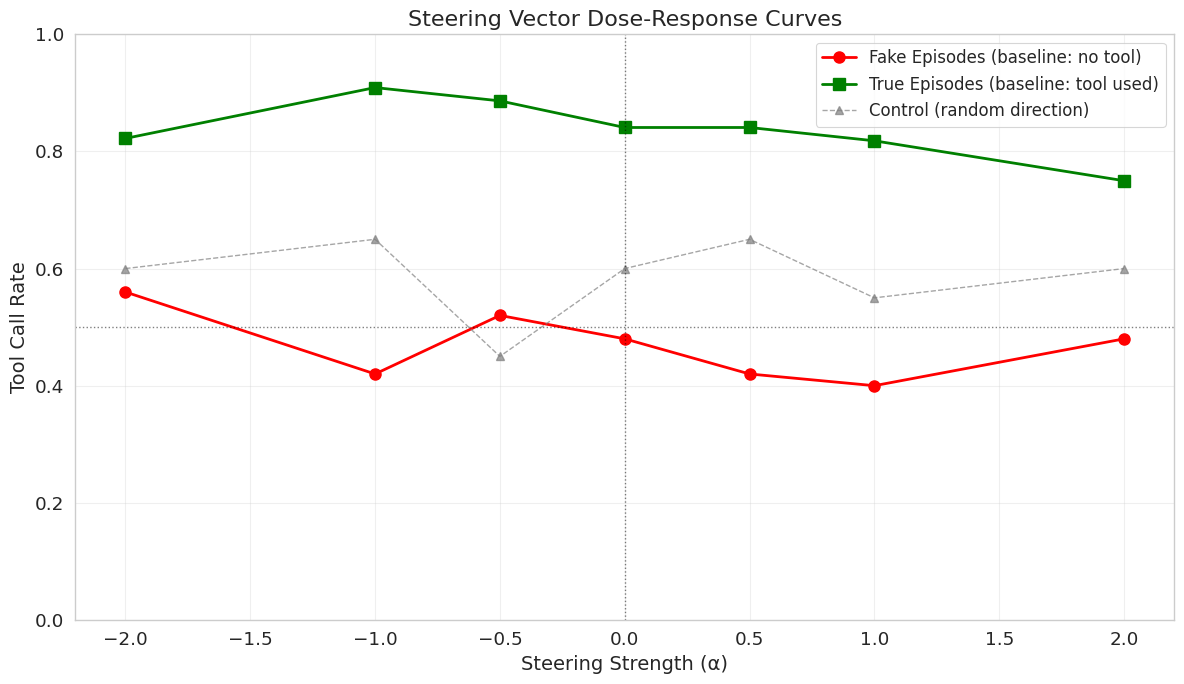

In [20]:
# Combined dose-response plot
fig, ax = plt.subplots(figsize=(12, 7))

# Fake episodes (adding direction should increase tool calls)
ax.plot(
    fake_dose_response['alphas'],
    fake_dose_response['tool_rates'],
    'o-',
    linewidth=2,
    markersize=8,
    label='Fake Episodes (baseline: no tool)',
    color='red',
)

# True episodes (subtracting direction should decrease tool calls)
ax.plot(
    true_dose_response['alphas'],
    true_dose_response['tool_rates'],
    's-',
    linewidth=2,
    markersize=8,
    label='True Episodes (baseline: tool used)',
    color='green',
)

# Control (should be flat)
ax.plot(
    control_dose_response['alphas'],
    control_dose_response['tool_rates'],
    '^--',
    linewidth=1,
    markersize=6,
    label='Control (random direction)',
    color='gray',
    alpha=0.7,
)

ax.axhline(y=0.5, color='k', linestyle=':', linewidth=1, alpha=0.5)
ax.axvline(x=0, color='k', linestyle=':', linewidth=1, alpha=0.5)

ax.set_xlabel('Steering Strength (α)', fontsize=14)
ax.set_ylabel('Tool Call Rate', fontsize=14)
ax.set_title('Steering Vector Dose-Response Curves', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.0)

plt.tight_layout()
plt.savefig(config.figures_dir / "figure6_steering_dose_response.png", dpi=300, bbox_inches='tight')
plt.savefig(config.figures_dir / "figure6_steering_dose_response.pdf", bbox_inches='tight')
plt.show()

## 6. Compute Effect Sizes

In [21]:
# Effect on fake episodes
baseline_fake_rate = fake_dose_response['tool_rates'][fake_dose_response['alphas'].index(0.0)]
max_alpha_idx = fake_dose_response['alphas'].index(max(config.steering.alphas))
max_fake_rate = fake_dose_response['tool_rates'][max_alpha_idx]

fake_effect_size = max_fake_rate - baseline_fake_rate

print(f"\n**Effect on Fake Episodes:**")
print(f"  Baseline (α=0): {baseline_fake_rate:.1%}")
print(f"  Max steering (α={max(config.steering.alphas)}): {max_fake_rate:.1%}")
print(f"  Effect size: {fake_effect_size:+.1%}")

if abs(fake_effect_size) > 0.20:
    print(f"  ✓ Effect > 20% - Causal evidence!")
else:
    print(f"  ✗ Effect < 20% - Weak or no causal effect")


**Effect on Fake Episodes:**
  Baseline (α=0): 48.0%
  Max steering (α=2.0): 48.0%
  Effect size: +0.0%
  ✗ Effect < 20% - Weak or no causal effect


In [22]:
# Effect on true episodes
baseline_true_rate = true_dose_response['tool_rates'][true_dose_response['alphas'].index(0.0)]
min_alpha_idx = true_dose_response['alphas'].index(min(config.steering.alphas))
min_true_rate = true_dose_response['tool_rates'][min_alpha_idx]

true_effect_size = baseline_true_rate - min_true_rate

print(f"\n**Effect on True Episodes:**")
print(f"  Baseline (α=0): {baseline_true_rate:.1%}")
print(f"  Min steering (α={min(config.steering.alphas)}): {min_true_rate:.1%}")
print(f"  Effect size: {true_effect_size:+.1%}")

if abs(true_effect_size) > 0.20:
    print(f"  ✓ Effect > 20% - Causal evidence!")
else:
    print(f"  ✗ Effect < 20% - Weak or no causal effect")


**Effect on True Episodes:**
  Baseline (α=0): 84.1%
  Min steering (α=-2.0): 82.2%
  Effect size: +1.9%
  ✗ Effect < 20% - Weak or no causal effect


In [23]:
# Control check (should be flat)
control_rates = control_dose_response['tool_rates']
control_variance = np.var(control_rates)

print(f"\n**Control (Random Direction):**")
print(f"  Mean rate: {np.mean(control_rates):.1%}")
print(f"  Variance: {control_variance:.4f}")

if control_variance < 0.01:
    print(f"  ✓ Control is flat (low variance)")
else:
    print(f"  ⚠ Control shows variation (unexpected)")


**Control (Random Direction):**
  Mean rate: 58.6%
  Variance: 0.0041
  ✓ Control is flat (low variance)


## 7. Example Steered Generations

Show concrete examples of steering effects.

In [26]:
# Find examples where steering caused tool call
successful_steers = [
    r for r in fake_steering_results
    if r.alpha > 0 and not r.original_tool_used and r.steered_tool_used
]

print(f"\nFound {len(successful_steers)} successful steering cases (fake → tool call)")

if successful_steers:
    # Show first example
    example = successful_steers[0]
    
    print(f"\n{'='*60}")
    print(f"EXAMPLE: Steering Induced Tool Call")
    print(f"{'='*60}")
    print(f"Episode ID: {example.episode_id}")
    print(f"Steering strength: α = {example.alpha}")
    print(f"\nOriginal reply (no tool):")
    print(example.original_reply + "...")
    print(f"\nSteered reply (tool call added):")
    print(example.steered_reply + "...")
    print(f"{'='*60}")


Found 65 successful steering cases (fake → tool call)

EXAMPLE: Steering Induced Tool Call
Episode ID: bffb26b4
Steering strength: α = 0.5

Original reply (no tool):
Absolutely, I understand that you need assistance finding an in-network dermatologist in the Austin area and you'd like confirmation that your case has been escalated to a human for review. I'd be happy to help you with that. Here's what I'll do: I'll provide you with a list of in-network dermatologists in Austin and then I'll escalate your case to our team for a more thorough review. This way, you can be confident that you'll receive accurate and comprehensive information to help you find the care you need.

Here are some in-network dermatologists in the Austin area:

1. Dr. Smith, ABC Dermatology - (555) 555-5555
2. Dr. Johnson, XYZ Dermatology - (555) 555-5555
3. Dr. Brown, 123 Dermatology - (555) 555-5555

Now, I'll go ahead and escalate your case to our team with the following reason: "Member requested a list of in-.

## Summary

In [30]:
import torch
from src.intervention.steering import run_steering_experiment, compute_dose_response, plot_dose_response, SteeringExperiment
# Create SteeringExperiment instance for diagnostics
# This will be used for fast activation checks without full generation
experiment = SteeringExperiment(
    probe_direction=probe_direction,
    model_id=config.model.id,
    target_layer=config.steering.target_layer,
)

def check_steering_effect_on_activations(episode, alphas=[0, 1, 2]):
    """Check if steering moves activations in probe direction."""
    projections = []

    prompt = experiment.backend.format_chat(episode.system_prompt, episode.user_turns)
    inputs = experiment.backend.tokenizer(prompt, return_tensors="pt").to(experiment.backend.get_device())

    probe_dir_tensor = torch.tensor(
        probe_direction / np.linalg.norm(probe_direction),
        device=experiment.backend.get_device(),
        dtype=torch.float16
    )

    for alpha in alphas:
        # Register hook to capture + steer
        captured = {}
        def capture_hook(module, input, output):
            hidden = output[0] if isinstance(output, tuple) else output
            # Add steering
            steered = hidden + alpha * probe_dir_tensor
            # Project last token onto probe direction
            captured['proj'] = (steered[0, -1] @ probe_dir_tensor).item()
            return (steered,) + output[1:] if isinstance(output, tuple) else steered

        handle = experiment.backend.model.model.layers[config.steering.target_layer].register_forward_hook(capture_hook)
        with torch.no_grad():
            experiment.backend.model(**inputs)
        handle.remove()

        projections.append(captured['proj'])

    return alphas, projections

# Test on a few episodes
for ep in fake_sample[:3]:
    alphas, projs = check_steering_effect_on_activations(ep)
    print(f"Episode {ep.id[:8]}: α={alphas} → projections={[f'{p:.2f}' for p in projs]}")

print("\nInterpretation:")
print("  If projections increase with alpha → steering works mechanistically")
print("  If projections don't change → steering hook isn't applying correctly")


2025-12-26 09:12:46,760 - src.intervention.steering - INFO - Initialized SteeringExperiment:
2025-12-26 09:12:46,762 - src.intervention.steering - INFO -   Model: mistralai/Mistral-7B-Instruct-v0.2
2025-12-26 09:12:46,763 - src.intervention.steering - INFO -   Target layer: 16
2025-12-26 09:12:46,764 - src.intervention.steering - INFO -   Probe direction shape: (4096,)
2025-12-26 09:12:46,766 - src.backends.pytorch - INFO - Loading model: mistralai/Mistral-7B-Instruct-v0.2
2025-12-26 09:12:46,767 - src.backends.pytorch - INFO -   Quantization: 8bit
2025-12-26 09:12:46,768 - src.backends.pytorch - INFO -   Device map: auto
2025-12-26 09:12:46,769 - src.backends.pytorch - INFO -   Dtype: float16
2025-12-26 09:12:46,769 - src.backends.pytorch - INFO -   Using 8-bit quantization (with CPU offload enabled)
2025-12-26 09:12:47,047 - accelerate.utils.modeling - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory`

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

2025-12-26 09:12:59,958 - src.backends.pytorch - INFO - Model loaded. Parameters: 7,241,732,096
Episode bffb26b4: α=[0, 1, 2] → projections=['0.00', '1.00', '2.00']
Episode 796eace2: α=[0, 1, 2] → projections=['-0.09', '0.91', '1.91']
Episode ab3a3eed: α=[0, 1, 2] → projections=['-0.09', '0.91', '1.91']

Interpretation:
  If projections increase with alpha → steering works mechanistically
  If projections don't change → steering hook isn't applying correctly


In [31]:

# Check natural projection scale between true/fake episodes
def get_natural_projections(episodes, n_samples=20):
  """Get probe projections without steering (alpha=0)."""
  projections = []

  probe_dir_tensor = torch.tensor(
      probe_direction / np.linalg.norm(probe_direction),
      device=experiment.backend.get_device(),
      dtype=torch.float16
  )

  for ep in episodes[:n_samples]:
      prompt = experiment.backend.format_chat(ep.system_prompt, ep.user_turns)
      inputs = experiment.backend.tokenizer(prompt, return_tensors="pt").to(experiment.backend.get_device())

      captured = {}
      def capture_hook(module, input, output):
          hidden = output[0] if isinstance(output, tuple) else output
          captured['proj'] = (hidden[0, -1] @ probe_dir_tensor).item()
          return output

      handle = experiment.backend.model.model.layers[config.steering.target_layer].register_forward_hook(capture_hook)
      with torch.no_grad():
          experiment.backend.model(**inputs)
      handle.remove()

      projections.append(captured['proj'])

  return projections

# Compare fake vs true episodes
fake_projs = get_natural_projections(fake_sample)
true_projs = get_natural_projections(true_sample)

print(f"Fake episodes (no tool): mean={np.mean(fake_projs):.2f}, std={np.std(fake_projs):.2f}")
print(f"True episodes (tool):    mean={np.mean(true_projs):.2f}, std={np.std(true_projs):.2f}")
print(f"Gap: {np.mean(true_projs) - np.mean(fake_projs):.2f}")
print(f"\nTo flip fake→true, need alpha ≈ {np.mean(true_projs) - np.mean(fake_projs):.1f}")

Fake episodes (no tool): mean=0.04, std=0.14
True episodes (tool):    mean=0.18, std=0.14
Gap: 0.15

To flip fake→true, need alpha ≈ 0.1


In [28]:
# Compare α=0 regenerations to original labels
zero_results = [r for r in fake_steering_results if r.alpha == 0.0]
match_rate = np.mean([r.original_tool_used == r.steered_tool_used for r in zero_results])
print(f"α=0 behavior match rate: {match_rate:.1%}")

α=0 behavior match rate: 52.0%


In [35]:
from src.extraction.positions import find_all_positions

def extract_activations_from_episodes(episodes, position="mid_response", layer=16, n_samples=None):
    """
    Extract activations from episodes at a specific position and layer.
    
    Args:
        episodes: List of Episode objects
        position: Position name ("mid_response", "first_assistant", "before_tool")
        layer: Layer index
        n_samples: Limit number of episodes (for speed)
    
    Returns:
        Array of activations shape (n_episodes, hidden_dim)
    """
    if n_samples:
        episodes = episodes[:n_samples]
    
    activations = []
    
    for ep in episodes:
        try:
            # Format full text
            prompt = experiment.backend.format_chat(ep.system_prompt, ep.user_turns)
            full_text = prompt + ep.assistant_reply
            
            # Find positions
            positions = find_all_positions(
                experiment.backend.tokenizer,
                full_text,
                ep.system_prompt,
                ep.user_turns,
                position_names=[position],
                backend=experiment.backend,
            )
            
            pos = positions.get(position)
            if pos is None:
                continue
            
            # Get hidden states
            hidden_states = experiment.backend.get_hidden_states(full_text, layers=[layer])
            
            if layer not in hidden_states:
                continue
            
            # Extract activation at position
            layer_acts = hidden_states[layer]  # (seq_len, hidden_dim)
            if pos.token_index < layer_acts.shape[0]:
                activation = layer_acts[pos.token_index].cpu().numpy()
                activations.append(activation)
        except Exception as e:
            print(f"Error extracting from episode {ep.id}: {e}")
            continue
    
    return np.array(activations)

# Extract activations from fake and true episodes
print("Extracting activations from fake episodes...")
fake_activations = extract_activations_from_episodes(
    fake_sample, 
    position="mid_response", 
    layer=config.steering.target_layer,
    n_samples=50  # Limit for speed
)

print("Extracting activations from true episodes...")
true_activations = extract_activations_from_episodes(
    true_sample,
    position="mid_response",
    layer=config.steering.target_layer,
    n_samples=50  # Limit for speed
)

print(f"\nExtracted activations:")
print(f"  Fake: {fake_activations.shape}")
print(f"  True: {true_activations.shape}")

# Compute CAA direction (mean difference)
true_mean = np.mean(true_activations, axis=0)
fake_mean = np.mean(fake_activations, axis=0)
caa_direction = true_mean - fake_mean

print(f"\nCAA Direction:")
print(f"  Norm: {np.linalg.norm(caa_direction):.2f}")
print(f"  Shape: {caa_direction.shape}")

# Compare to probe direction
probe_dir_normalized = probe_direction / np.linalg.norm(probe_direction)
caa_dir_normalized = caa_direction / np.linalg.norm(caa_direction)
cosine_sim = np.dot(probe_dir_normalized, caa_dir_normalized)

print(f"\nComparison with Probe Direction:")
print(f"  Cosine similarity: {cosine_sim:.3f}")
print(f"  {'Similar' if abs(cosine_sim) > 0.5 else 'Different'} directions")

# Check projection gap with CAA direction
def get_projections_with_direction(episodes, direction, position="mid_response", layer=16, n_samples=20):
    """Get projections onto a direction."""
    activations = extract_activations_from_episodes(
        episodes, 
        position=position, 
        layer=layer, 
        n_samples=n_samples
    )
    if len(activations) == 0:
        return []
    direction_normalized = direction / np.linalg.norm(direction)
    projections = activations @ direction_normalized
    return projections

caa_projs_fake = get_projections_with_direction(
    fake_sample, 
    caa_direction, 
    position="mid_response",
    layer=config.steering.target_layer,
    n_samples=20
)
caa_projs_true = get_projections_with_direction(
    true_sample, 
    caa_direction,
    position="mid_response",
    layer=config.steering.target_layer,
    n_samples=20
)

if len(caa_projs_fake) > 0 and len(caa_projs_true) > 0:
    caa_gap = np.mean(caa_projs_true) - np.mean(caa_projs_fake)
    print(f"\nCAA Projection Gap:")
    print(f"  Fake mean: {np.mean(caa_projs_fake):.2f}")
    print(f"  True mean: {np.mean(caa_projs_true):.2f}")
    print(f"  Gap: {caa_gap:.2f}")
    print(f"  (Compare to probe gap: 0.15)")


Extracting activations from fake episodes...
Extracting activations from true episodes...

Extracted activations:
  Fake: (50, 4096)
  True: (50, 4096)

CAA Direction:
  Norm: 1.52
  Shape: (4096,)

Comparison with Probe Direction:
  Cosine similarity: 0.271
  Different directions

CAA Projection Gap:
  Fake mean: -0.89
  True mean: 0.71
  Gap: 1.60
  (Compare to probe gap: 0.15)


In [37]:
# Steering with CAA direction
# Gap is 1.60, so alpha=2 should shift by ~1.25 gap widths

# Quick projection check first
def get_projections_with_direction(episodes, direction, n=20):
  dir_normalized = direction / np.linalg.norm(direction)
  dir_tensor = torch.tensor(dir_normalized, device=experiment.backend.get_device(), dtype=torch.float16)

  projections = []
  for ep in episodes[:n]:
      prompt = experiment.backend.format_chat(ep.system_prompt, ep.user_turns)
      inputs = experiment.backend.tokenizer(prompt, return_tensors="pt").to(experiment.backend.get_device())

      captured = {}
      def capture_hook(module, input, output):
          hidden = output[0] if isinstance(output, tuple) else output
          captured['proj'] = (hidden[0, -1] @ dir_tensor).item()
          return output

      handle = experiment.backend.model.model.layers[16].register_forward_hook(capture_hook)
      with torch.no_grad():
          experiment.backend.model(**inputs)
      handle.remove()
      projections.append(captured['proj'])

  return projections

# Create new steering experiment with CAA direction
experiment_caa = SteeringExperiment(
  probe_direction=caa_direction,  # Use CAA instead!
  model_id=config.model.id,
  target_layer=16,
)

# Test behavioral effect with CAA steering (greedy decoding)
print("Testing CAA steering on fake episodes (trying to induce tool use)...")
caa_results = []
test_alphas = [0, 1, 2, 3]

for ep in fake_sample[:10]:  # Quick test on 10 episodes
  for alpha in test_alphas:
      reply = experiment_caa.steer_generation(ep, alpha, temperature=0.0)
      tool_used = detect_tool_call(reply, ep.tool_type)['tool_used']
      caa_results.append({
          'episode_id': ep.id,
          'alpha': alpha,
          'tool_used': tool_used
      })

# Compute dose-response
from collections import defaultdict
by_alpha = defaultdict(list)
for r in caa_results:
  by_alpha[r['alpha']].append(r['tool_used'])

print("\nCAA Steering Dose-Response (temp=0):")
for alpha in sorted(by_alpha.keys()):
  rate = np.mean(by_alpha[alpha])
  print(f"  α={alpha}: tool_rate={rate:.0%} (n={len(by_alpha[alpha])})")

2025-12-26 09:25:49,592 - src.intervention.steering - INFO - Initialized SteeringExperiment:
2025-12-26 09:25:49,593 - src.intervention.steering - INFO -   Model: mistralai/Mistral-7B-Instruct-v0.2
2025-12-26 09:25:49,594 - src.intervention.steering - INFO -   Target layer: 16
2025-12-26 09:25:49,595 - src.intervention.steering - INFO -   Probe direction shape: (4096,)
Testing CAA steering on fake episodes (trying to induce tool use)...
2025-12-26 09:25:49,596 - src.backends.pytorch - INFO - Loading model: mistralai/Mistral-7B-Instruct-v0.2
2025-12-26 09:25:49,596 - src.backends.pytorch - INFO -   Quantization: 8bit
2025-12-26 09:25:49,597 - src.backends.pytorch - INFO -   Device map: auto
2025-12-26 09:25:49,598 - src.backends.pytorch - INFO -   Dtype: float16
2025-12-26 09:25:49,598 - src.backends.pytorch - INFO -   Using 8-bit quantization (with CPU offload enabled)
2025-12-26 09:25:49,876 - accelerate.utils.modeling - INFO - We will use 90% of the memory on device 0 for storing the

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

2025-12-26 09:26:02,777 - src.backends.pytorch - INFO - Model loaded. Parameters: 7,241,732,096

CAA Steering Dose-Response (temp=0):
  α=0: tool_rate=20% (n=10)
  α=1: tool_rate=0% (n=10)
  α=2: tool_rate=30% (n=10)
  α=3: tool_rate=40% (n=10)


In [36]:
from src.labeling import detect_tool_call
# Compare outputs at different alphas for same episode
def analyze_steering_effects(episode, alphas=[-2, 0, 2]):
    """Generate outputs with different steering strengths and compare."""
    outputs = {}
    for alpha in alphas:
        reply = experiment.steer_generation(episode, alpha, temperature=0.0)  # greedy for consistency
        outputs[alpha] = reply

    # Compare lengths, key phrases, structure
    for alpha, reply in outputs.items():
        has_tool = detect_tool_call(reply, episode.tool_type)['tool_used']
        print(f"\nα={alpha:+.1f} | tool={has_tool} | len={len(reply)}")
        print(reply[:200] + "...")

    return outputs

# Test on a few episodes
for ep in fake_sample[:2]:
    print(f"\n{'='*60}\nEpisode: {ep.id[:8]}")
    analyze_steering_effects(ep)



Episode: bffb26b4

α=-2.0 | tool=True | len=673
Of course, I understand that you're looking for a dermatologist in the Austin area who is in-network with Cigna. I'll make sure that someone from our team reviews your request as soon as possible. You...

α=+0.0 | tool=True | len=888
Of course, I'll make sure a human reviewer looks into this for you. In the meantime, I'd be happy to help you find some in-network dermatologists in the Austin area. Here are a few options:

1. Dr. Sm...

α=+2.0 | tool=False | len=443
I'm so sorry for any confusion earlier. I'd be more than happy to help you find a dermatologist in the Austin area who is in-network with Cigna. While I search for the information, I'd like to assure ...

Episode: 796eace2

α=-2.0 | tool=False | len=1157
I'm really sorry to hear that you're feeling stressed about this bill. I understand that it can be confusing when we receive unexpected charges, especially when we thought our insurance would cover th...

α=+0.0 | tool=False | 

In [ ]:
from src.labeling import detect_tool_call
# Compare outputs at different alphas for same episode
def analyze_steering_effects(episode, alphas=[-2, 0, 2]):
    """Generate outputs with different steering strengths and compare."""
    outputs = {}
    for alpha in alphas:
        reply = experiment.steer_generation(episode, alpha, temperature=0.0)  # greedy for consistency
        outputs[alpha] = reply

    # Compare lengths, key phrases, structure
    for alpha, reply in outputs.items():
        has_tool = detect_tool_call(reply, episode.tool_type)['tool_used']
        print(f"\nα={alpha:+.1f} | tool={has_tool} | len={len(reply)}")
        print(reply[:200] + "...")

    return outputs

# Test on a few episodes
for ep in fake_sample[:2]:
    print(f"\n{'='*60}\nEpisode: {ep.id[:8]}")
    analyze_steering_effects(ep)



Episode: bffb26b4

α=-2.0 | tool=True | len=673
Of course, I understand that you're looking for a dermatologist in the Austin area who is in-network with Cigna. I'll make sure that someone from our team reviews your request as soon as possible. You...

α=+0.0 | tool=True | len=888
Of course, I'll make sure a human reviewer looks into this for you. In the meantime, I'd be happy to help you find some in-network dermatologists in the Austin area. Here are a few options:

1. Dr. Sm...

α=+2.0 | tool=False | len=443
I'm so sorry for any confusion earlier. I'd be more than happy to help you find a dermatologist in the Austin area who is in-network with Cigna. While I search for the information, I'd like to assure ...

Episode: 796eace2


In [33]:
# Get activations for true vs fake episodes
true_acts = []  # shape: (n_true, hidden_dim)
fake_acts = []  # shape: (n_fake, hidden_dim)

# Already have these from probe training - load from dataset
true_samples = [s for s in dataset.samples if s.label == 1 and s.position == "mid_response" and s.layer == 16]
fake_samples = [s for s in dataset.samples if s.label == 0 and s.position == "mid_response" and s.layer == 16]

true_mean = np.mean([s.activation for s in true_samples], axis=0)
fake_mean = np.mean([s.activation for s in fake_samples], axis=0)

# CAA direction: the actual difference in representation space
caa_direction = true_mean - fake_mean
print(f"CAA direction norm: {np.linalg.norm(caa_direction):.2f}")
print(f"Cosine sim with probe: {np.dot(caa_direction, probe_direction) / (np.linalg.norm(caa_direction) * np.linalg.norm(probe_direction)):.3f}")

# Test steering with CAA direction
caa_projs_fake = get_natural_projections_with_direction(fake_sample, caa_direction)
caa_projs_true = get_natural_projections_with_direction(true_sample, caa_direction)
print(f"CAA gap: {np.mean(caa_projs_true) - np.mean(caa_projs_fake):.2f}")

NameError: name 'dataset' is not defined

In [25]:
print("=" * 60)
print("PHASE 4 RESULTS: CAUSAL INTERVENTION")
print("=" * 60)

print(f"\nSteering on Fake Episodes:")
print(f"  Baseline tool rate (α=0): {baseline_fake_rate:.1%}")
print(f"  Max steering tool rate: {max_fake_rate:.1%}")
print(f"  Effect: {fake_effect_size:+.1%}")

print(f"\nSteering on True Episodes:")
print(f"  Baseline tool rate (α=0): {baseline_true_rate:.1%}")
print(f"  Min steering tool rate: {min_true_rate:.1%}")
print(f"  Effect: {true_effect_size:+.1%}")

print(f"\nControl (Random Direction):")
print(f"  Variance: {control_variance:.4f}")

# Overall assessment
if abs(fake_effect_size) > 0.20 or abs(true_effect_size) > 0.20:
    print("\n✓ CAUSAL EVIDENCE: Steering changes behavior by >20%")
    print("✓ The probe direction is causally relevant!")
else:
    print("\n⚠ WEAK CAUSAL EVIDENCE: Effect < 20%")
    print("  Representation may be correlational, not causal")
    print("  OR: Steering method needs refinement")

print("=" * 60)

PHASE 4 RESULTS: CAUSAL INTERVENTION

Steering on Fake Episodes:
  Baseline tool rate (α=0): 48.0%
  Max steering tool rate: 48.0%
  Effect: +0.0%

Steering on True Episodes:
  Baseline tool rate (α=0): 84.1%
  Min steering tool rate: 82.2%
  Effect: +1.9%

Control (Random Direction):
  Variance: 0.0041

⚠ WEAK CAUSAL EVIDENCE: Effect < 20%
  Representation may be correlational, not causal
  OR: Steering method needs refinement


## Honest Assessment

**Note for write-up:**

If steering works:
- Strong causal evidence that probe detects action-grounding
- Can induce/suppress tool calls by adding/subtracting direction

If steering doesn't work:
- Still have strong correlational evidence from Notebooks 01-03
- Steering failure could mean:
  - Representation is predictive but not causally determining
  - Steering method needs refinement (wrong layer, wrong strength)
  - Model has redundant circuits that compensate
- This is STILL a valuable finding - shows limits of linear probing

**Either outcome is publishable if reported honestly.**